### Buoy Data
* Connecting to buoy data via csv url
* Used pandas dataframe to stage data
* Buoy 45026
* Location: Stevensville, MI
* cooridinates: 41.982 N 86.619 W (41°58'55" N 86°37'10" W)

### Connecting To The Data

In [88]:
import pandas as pd
import numpy as np
import re #importing regex for string parsing

In [132]:
# Connection
import pandas as pd
import numpy as np
import re #importing regex for string parsing
pd.set_option('display.max_columns', None)

#reading website data as csv
buoy_data = pd.read_csv(
    'https://www.ndbc.noaa.gov/data/realtime2/45026.txt',
    sep = r'\s+',
    header = 0,
    index_col = None
)

#dataframe to drop first record since first record represents units of measurements for fields within dataset
df = buoy_data.iloc[1:]
df1 = pd.DataFrame(df)

### Data Manipulation

In [134]:
# renaming fields
df1.rename(columns = {
    '#YY':'Year','MM':'Month','DD':'Day','hh':'Hour','mm':'Minute','WDIR':'Wind_Dir','WSPD':'Wind_Speed','GST':'Wind_Gust','WVHT':'Wave_Height',
    'DPD':'Dominant_Wave_Prd','APD':'Average_Wave_Prd','MWD':'Dominant_Wave_Dir','PRES':'Sea_Level_Pres','ATMP':'Air_Temperature',
    'WTMP':'Surface_Water_Temperature','DEWP':'Dew_Point_Temp','VIS':'Station_Visibility','PTDY':'Pressure_Tendency'
},inplace=True)

# Find and Replace all 'MM' values as null as this is likely a nullable value from source data - from observation
df1.replace(to_replace='MM',value = 0,inplace=True)

# appending datetime stamp field to existing df
df1.insert(19,'Timestamp',(df1['Year'] + '-' + df1['Month'] + '-' + df1['Day']+ ' ' + df1['Hour'] + ':' + df1['Minute']).astype('str'),True)
df1.insert(20,'yyyy-mm-dd',(df1['Year'] + '-' + df1['Month'] + '-' + df1['Day']).astype('str'))
df1.insert(21,'yyyy_mm_dd',(df1['Year']+df1['Month']+df1['Day']).astype('int'))

#grouping and sorting dataframe by timestamp field| ensure most current record at top of file
df1.sort_values(by = 'Timestamp',ascending = False, inplace = True)

#############################################
#conversions
df1.insert(14,'Air_Temp_Deg_F',((df1['Air_Temperature'].astype('float')*(9/5))+32)) #converting air temp to fahrenheit
#df1.insert(15,'Surface_Water_Temp',((df1['WTMP'].astype('float')*(9/5))+32)) # converting surface water temp to fahrenheit
df1.insert(16,'Surface_Water_Temp_Deg_F',((df1['Surface_Water_Temperature'].astype('float')*(9/5))+32)) # converting surface water temp to fahrenheit
df1.insert(18,'DewPoint_Temp_Deg_F',((df1['Dew_Point_Temp'].astype('float')*(9/5))+32)) # converting dewpoint temp to fahrenheit
df1.insert(7,'Wind_Speed_MPH',(df1['Wind_Speed'].astype('float')*2.237)) # converting windspeed to MPH
df1.insert(9,'Wind_Gust_MPH',(df1['Wind_Gust'].astype('float')*2.237)) # converting wind gust to MPH
df1.insert(11,'Wave_Height_FT',(df1['Wave_Height'].astype('float')*3.281)) # converting wave height to feet


###########################################
# appending condition for Wind and Wave Direction values
# compass direction dictionary
a = {
    'min_val':[0,11.25,33.75,56.25,78.75,101.25,123.75,146.25,168.75,191.25,213.75,236.25,258.75,281.25,303.75,326.25,348.75],
    'max_val':[11.24,33.74,56.24,78.24,101.24,123.74,146.24,168.74,191.24,213.74,236.24,258.74,281.24,303.74,326.24,348.74,360.00],
    'direction':['N','NNE','NE','ENE','E','ESE','SE','SSE','S','SSW','SW','WSW','W','WNW','NW','NNW','N']
}
# changing to df
df_a = pd.DataFrame(a)

# function to apply compass direction to wave_direction data
def get_corresponding_value(i):
    for _, row in df_a.iterrows():
        if row['min_val'] <=i<=row['max_val']:
            return row['direction']
    return None

#appended values to df1 for wave direction
df1.insert(15,'Wave_Direction', df1['Dominant_Wave_Dir'].astype('float').apply(get_corresponding_value))
#appending values to df1 for wind direction
df1.insert(6,'Wind_Direction', df1['Wind_Dir'].astype('float').apply(get_corresponding_value))

C:\Users\errol\AppData\Local\Temp\ipykernel_4912\1785018416.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1.replace(to_replace='MM',value = 0,inplace=True)


#### Data Sanity Check

In [135]:
df1.tail(5)

,Year,Month,Day,Hour,Minute,Wind_Dir,Wind_Direction,Wind_Speed,Wind_Speed_MPH,Wind_Gust,Wind_Gust_MPH,Wave_Height,Wave_Height_FT,Dominant_Wave_Prd,Average_Wave_Prd,Dominant_Wave_Dir,Wave_Direction,Sea_Level_Pres,Air_Temperature,Air_Temp_Deg_F,Surface_Water_Temperature,Surface_Water_Temp_Deg_F,Dew_Point_Temp,DewPoint_Temp_Deg_F,Station_Visibility,Pressure_Tendency,TIDE,Timestamp,yyyy-mm-dd,yyyy_mm_dd
6421,2024,10,11,00,40,80,E,4.0,8.948,5.0,11.185,0.2,0.6562,0,0,24,NNE,1022.9,16.7,62.06,18.8,65.84,9.5,49.10,0,0,0,2024-10-11 00:40,2024-10-11,20241011
6422,2024,10,11,00,30,80,E,4.0,8.948,5.0,11.185,0.2,0.6562,0,0,27,NNE,1022.8,16.9,62.42,18.8,65.84,9.7,49.46,0,0,0,2024-10-11 00:30,2024-10-11,20241011
6423,2024,10,11,00,20,80,E,4.0,8.948,5.0,11.185,0.2,0.6562,0,0,24,NNE,1022.8,17.0,62.60,18.8,65.84,9.6,49.28,0,0,0,2024-10-11 00:20,2024-10-11,20241011
6424,2024,10,11,00,10,70,ENE,4.0,8.948,5.0,11.185,0.3,0.9843,0,0,26,NNE,1022.8,17.1,62.78,18.8,65.84,10.0,50.00,0,0,0,2024-10-11 00:10,2024-10-11,20241011
6425,2024,10,11,00,00,70,ENE,4.0,8.948,5.0,11.185,0.2,0.6562,0,0,35,NE,1022.8,17.4,63.32,18.8,65.84,10.1,50.18,0,+0.3,0,2024-10-11 00:00,2024-10-11,20241011


In [96]:
# Min & Max load date
df1['yyyy-mm-dd'].min(),df1['yyyy-mm-dd'].max()
# interesting... data doesn't load after 11/25 ?

('2024-10-11', '2024-11-25')

---

### Analysis

##### Mean Surface Water Temperatures Grouped In Days

In [203]:
sp_df = df1.groupby(['yyyy-mm-dd']).agg(mean_temp = ('Surface_Water_Temp_Deg_F','mean')).reset_index()

In [205]:
sp_df.head()

,yyyy-mm-dd,mean_temp
0,2024-10-11,65.905106
1,2024-10-12,66.652571
2,2024-10-13,65.352714
3,2024-10-14,64.706761
4,2024-10-15,64.505734


In [166]:
sp_df.describe()

,Surface_Water_Temp_Deg_F
,mean
count,46.000000
mean,59.182058
std,4.567619
min,49.450935
25%,55.965212
50%,59.804336
75%,62.644357
max,66.652571


In [207]:
sp_df.shape

(46, 2)

### Graphing Water Surface Temps Over Time To Visualize Trends In Temperature

<Axes: xlabel='yyyy-mm-dd', ylabel='mean_temp'>

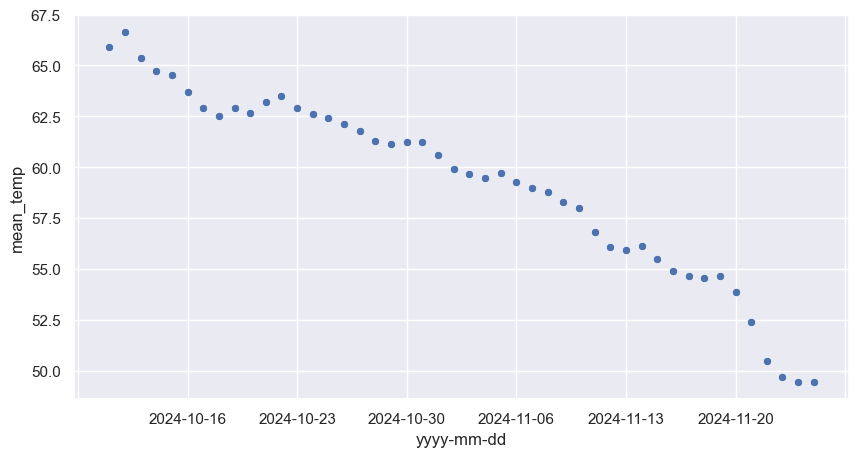

In [231]:
# converting to dataframe so to plot in graph
df3 = pd.DataFrame(sp_df)

# scatter plot of mean lake surface water temps from mid Oct 2024 - End of November 2024
import seaborn as sns
import matplotlib.pyplot as plt, matplotlib.dates as mdates

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7)) # setting 7 day intervals on x-axis
sns.set(rc={'figure.figsize':(12, 5)}) # setting size of graph
sns.scatterplot(
    x=df3['yyyy-mm-dd'],
    y=df3['mean_temp']
    ,data=corr)

#### Correlation Matrix To Understand Relationship
* Trying to see if there's any relationship between wind speed, direction, dewpoint, wave height to surface water temps

In [12]:
df2 = df1[[
    'Wind_Dir',
    'Wind_Speed_MPH',
    'Wind_Gust_MPH',
    'Dominant_Wave_Dir',
    'Air_Temp_Deg_F',
    'DewPoint_Temp_Deg_F',
    'Wave_Height_FT',
    'Surface_Water_Temp_Deg_F'
]]

# correlation coefficient matrix
corr = df2.corr(method='pearson')
#corr output
df2.corr(method='pearson')

,Wind_Dir,Wind_Speed_MPH,Wind_Gust_MPH,Dominant_Wave_Dir,Air_Temp_Deg_F,DewPoint_Temp_Deg_F,Wave_Height_FT,Surface_Water_Temp_Deg_F
Wind_Dir,1.000000,0.214536,0.216241,0.203839,0.029186,0.050938,0.312045,-0.158441
Wind_Speed_MPH,0.214536,1.000000,0.977538,-0.040182,-0.052922,0.058248,0.648483,-0.147994
Wind_Gust_MPH,0.216241,0.977538,1.000000,0.008342,-0.080268,0.028354,0.692249,-0.149173
Dominant_Wave_Dir,0.203839,-0.040182,0.008342,1.000000,-0.191900,-0.183929,0.473169,0.100312
Air_Temp_Deg_F,0.029186,-0.052922,-0.080268,-0.191900,1.000000,0.837274,-0.294815,0.599926
DewPoint_Temp_Deg_F,0.050938,0.058248,0.028354,-0.183929,0.837274,1.000000,-0.189824,0.353990
Wave_Height_FT,0.312045,0.648483,0.692249,0.473169,-0.294815,-0.189824,1.000000,-0.129813
Surface_Water_Temp_Deg_F,-0.158441,-0.147994,-0.149173,0.100312,0.599926,0.353990,-0.129813,1.000000


### Notes
---

Appears that surface water temperature is more influenced by air temperature, which has the strongest correlation,
followed by the dewpoint temperature and then the dominant wave direction (the point of highest wave energy direction that wave is traveling from);
I wonder if this can mean, when surface water is warmer, if there is a slight influence when wind direction is from shore (where wind direction is from the east)....does dominant wind direction ever come from the shore? I'll need to check this out.  Could see if I can pull stationary thermostat temps maybe at local weather station to correlte with the buoy ir temp

#### CSV Output

In [33]:
# writing output to csv file 
df1.to_csv(r'C:/Users/errol/Documents/test_output3.csv')